In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Lambda, Convolution1D, LSTM, SimpleRNN, LSTMCell

np.set_printoptions(edgeitems=np.inf)

from tensorflow.compat.v1.keras.backend import set_session
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
config.log_device_placement = True
sess = tf.compat.v1.Session(config=config)
set_session(sess)

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce RTX 2060, pci bus id: 0000:01:00.0, compute capability: 7.5
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device



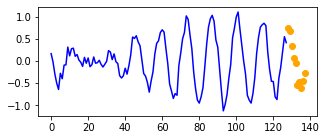

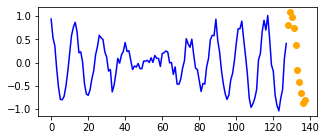

The training data X (solid) line and the next predictions Y (dotted), which should be forecasted.


In [2]:
np.random.seed(1)
seq_length = 128
look_ahead =  10


def gen_data(size=1000, noise=0.1):
    s = seq_length + look_ahead
    d = np.zeros((size, s,1))
    for i in range(size):
        start = np.random.uniform(0, 2*np.pi)
        d[i,:,0] = np.sin(start + np.linspace(0, 20*np.pi, s)) * np.sin(start + np.linspace(0, np.pi, s)) + np.random.normal(0,noise,s)
    return d[:,0:seq_length], d[:,seq_length:s]


X,Y = gen_data()
x0 = X[:800]
y0 = Y[:800]
x2 = X[800:]
y2 = Y[800:]
for i in range(2):
    plt.figure(num=None, figsize=(5,2))  
    plt.plot(range(0, seq_length),X[i,:,0],'b-')
    plt.plot(range(seq_length, seq_length + look_ahead),Y[i,:,0],'bo',color='orange')

plt.show()
print('The training data X (solid) line and the next predictions Y (dotted), which should be forecasted.')

## A) 1D Convolution without dilation rate

In [3]:
def slice(x, slice_length):
    return x[:,-slice_length:,:]

In [4]:
n_epochs = 50
batch_size = 8
lr = 1e-3
look_ahead = 10

modelA = Sequential()
modelA.add(Convolution1D(32, kernel_size=5, strides=1, batch_input_shape=(None, None, 1), padding='same'))
modelA.add(Convolution1D(32, kernel_size=5, strides=1, padding='same'))
modelA.add(Convolution1D(32, kernel_size=5, strides=1, padding='same'))
modelA.add(Convolution1D(32, kernel_size=5, strides=1, padding='same'))
modelA.add(Dense(1))
modelA.add(Lambda(slice, arguments={'slice_length':look_ahead}))
modelA.compile(optimizer="adam", loss='mse', lr=lr, metrics=['mse'])
modelA.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 32)          192       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 32)          5152      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 32)          5152      
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 32)          5152      
_________________________________________________________________
dense (Dense)                (None, None, 1)           33        
_________________________________________________________________
lambda (Lambda)              (None, None, 1)           0         
Total params: 15,681
Trainable params: 15,681
Non-trainable params: 0
____________________________________________________

In [5]:
history = modelA.fit(x0, y0, batch_size=batch_size, epochs=n_epochs, validation_data=(x2, y2));

Train on 800 samples, validate on 200 samples
Epoch 1/50
800/800 [==============================] - 3s 4ms/sample - loss: 0.0378 - mse: 0.0378 - val_loss: 0.0192 - val_mse: 0.0192
Epoch 2/50
800/800 [==============================] - 0s 461us/sample - loss: 0.0194 - mse: 0.0194 - val_loss: 0.0178 - val_mse: 0.0178
Epoch 3/50
800/800 [==============================] - 0s 430us/sample - loss: 0.0178 - mse: 0.0178 - val_loss: 0.0157 - val_mse: 0.0157
Epoch 4/50
800/800 [==============================] - 0s 433us/sample - loss: 0.0171 - mse: 0.0171 - val_loss: 0.0198 - val_mse: 0.0198
Epoch 5/50
800/800 [==============================] - 0s 433us/sample - loss: 0.0167 - mse: 0.0167 - val_loss: 0.0152 - val_mse: 0.0152
Epoch 6/50
800/800 [==============================] - 0s 437us/sample - loss: 0.0161 - mse: 0.0161 - val_loss: 0.0148 - val_mse: 0.0148
Epoch 7/50
800/800 [==============================] - 0s 454us/sample - loss: 0.0162 - mse: 0.0162 - val_loss: 0.0152 - val_mse: 0.0152
Epoc

Train MSE: 0.016269548311829567
Validate MSE: 0.015628240182995797


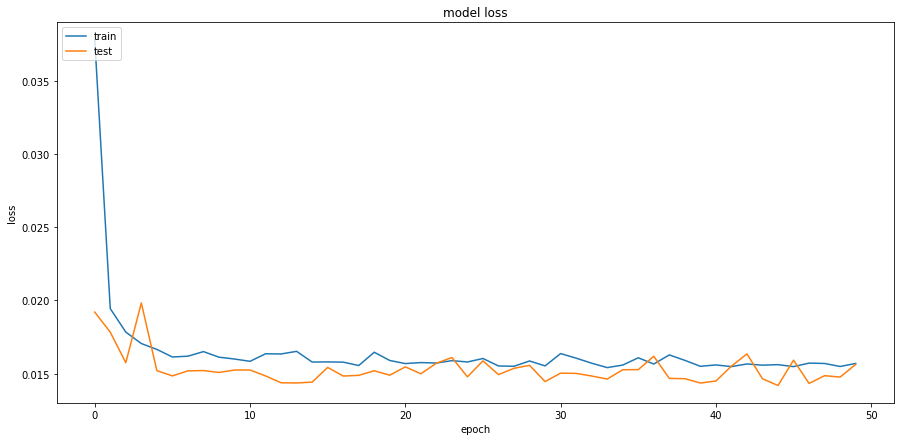

In [6]:
score_train = modelA.evaluate(x0, y0, verbose=0)
score_val = modelA.evaluate(x2, y2, verbose=0)
print(f"Train MSE: {score_train[0]}")
print(f"Validate MSE: {score_val[0]}")
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15, 7))
axes.plot(history.history['mse'])
axes.plot(history.history['val_mse'])
axes.set_title('model loss')
axes.set_ylabel('loss')
axes.set_xlabel('epoch')
axes.legend(['train', 'test'], loc='upper left');

(1, 128, 1)
(1, 10, 1)

(1, 138, 1)
(1, 10, 1)

(1, 148, 1)
(1, 10, 1)

(1, 158, 1)
(1, 10, 1)

(1, 168, 1)
(1, 10, 1)

(1, 178, 1)
(1, 10, 1)

(1, 188, 1)
(1, 10, 1)

(1, 198, 1)
(1, 10, 1)

(1, 208, 1)
(1, 10, 1)

(1, 218, 1)
(1, 10, 1)

(1, 228, 1)
(1, 10, 1)

(1, 238, 1)
(1, 10, 1)



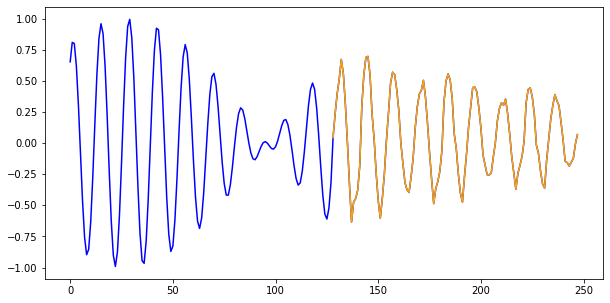

In [37]:
n_tests = 1
x_test,y_test = gen_data(size=n_tests,noise=0.0)
for i in range(12):
    print(x_test.shape)
    y = modelA.predict(x_test)
    print(y.shape)
    print()
    x_test = np.concatenate((x_test, y), axis=1)
y_pred = x_test[:, 128:]


fig = plt.figure(figsize=(10, 5))
for i in range(n_tests):
    plt.plot(range(0, 248),x_test[i,:,0],'b-')
    plt.plot(range(128, 248),y_pred[i,:,0],'b-', color='orange')

## B) 1D Convolution with dilation rate

In [8]:
n_epochs = 50
batch_size = 8
lr = 1e-3
look_ahead = 10

modelB = Sequential()
modelB.add(Convolution1D(32, kernel_size=5, strides=1, batch_input_shape=(None, None, 1), padding='causal', dilation_rate=1))
modelB.add(Convolution1D(32, kernel_size=5, strides=1, padding='causal', dilation_rate=2))
modelB.add(Convolution1D(32, kernel_size=5, strides=1, padding='causal', dilation_rate=4))
modelB.add(Convolution1D(32, kernel_size=5, strides=1, padding='causal', dilation_rate=8))
modelB.add(Dense(1))
modelB.add(Lambda(slice, arguments={'slice_length':look_ahead}))
modelB.compile(optimizer="adam", loss='mse', lr=lr, metrics=['mse'])
modelB.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, None, 32)          192       
_________________________________________________________________
conv1d_5 (Conv1D)            (None, None, 32)          5152      
_________________________________________________________________
conv1d_6 (Conv1D)            (None, None, 32)          5152      
_________________________________________________________________
conv1d_7 (Conv1D)            (None, None, 32)          5152      
_________________________________________________________________
dense_1 (Dense)              (None, None, 1)           33        
_________________________________________________________________
lambda_1 (Lambda)            (None, None, 1)           0         
Total params: 15,681
Trainable params: 15,681
Non-trainable params: 0
__________________________________________________

In [9]:
history = modelB.fit(x0, y0, batch_size=batch_size, epochs=n_epochs, validation_data=(x2, y2));

Train on 800 samples, validate on 200 samples
Epoch 1/50
800/800 [==============================] - 2s 2ms/sample - loss: 0.0247 - mse: 0.0247 - val_loss: 0.0136 - val_mse: 0.0136
Epoch 2/50
800/800 [==============================] - 1s 665us/sample - loss: 0.0142 - mse: 0.0142 - val_loss: 0.0128 - val_mse: 0.0128
Epoch 3/50
800/800 [==============================] - 1s 657us/sample - loss: 0.0129 - mse: 0.0129 - val_loss: 0.0124 - val_mse: 0.0124
Epoch 4/50
800/800 [==============================] - 0s 489us/sample - loss: 0.0133 - mse: 0.0133 - val_loss: 0.0110 - val_mse: 0.0110
Epoch 5/50
800/800 [==============================] - 0s 567us/sample - loss: 0.0130 - mse: 0.0130 - val_loss: 0.0149 - val_mse: 0.0149
Epoch 6/50
800/800 [==============================] - 0s 608us/sample - loss: 0.0132 - mse: 0.0132 - val_loss: 0.0129 - val_mse: 0.0129
Epoch 7/50
800/800 [==============================] - 1s 636us/sample - loss: 0.0127 - mse: 0.0127 - val_loss: 0.0113 - val_mse: 0.0113
Epoc

Train MSE: 0.011907197721302509
Validate MSE: 0.010925323367118836


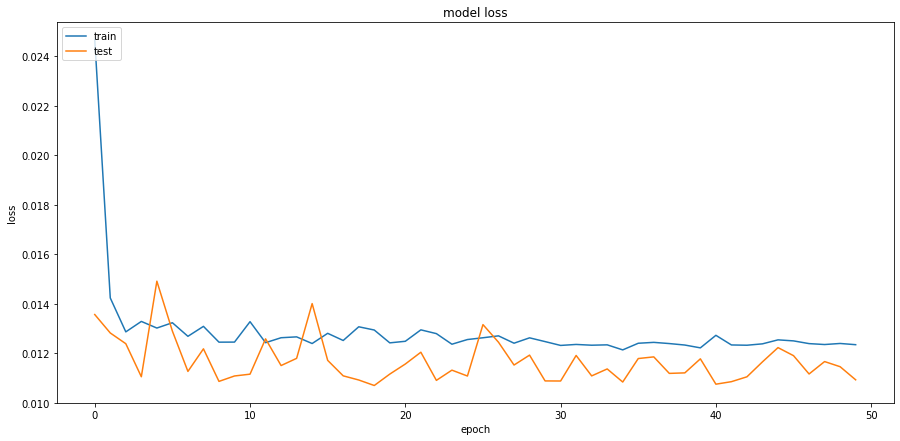

In [10]:
score_train = modelB.evaluate(x0, y0, verbose=0)
score_val = modelB.evaluate(x2, y2, verbose=0)
print(f"Train MSE: {score_train[0]}")
print(f"Validate MSE: {score_val[0]}")
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15, 7))
axes.plot(history.history['mse'])
axes.plot(history.history['val_mse'])
axes.set_title('model loss')
axes.set_ylabel('loss')
axes.set_xlabel('epoch')
axes.legend(['train', 'test'], loc='upper left');

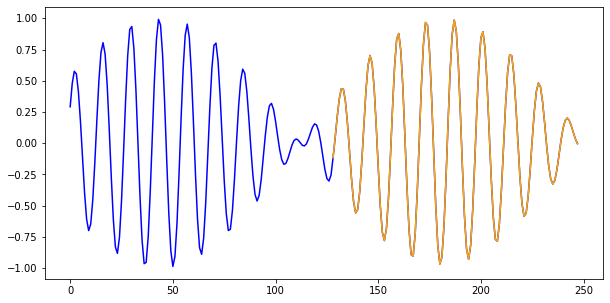

In [28]:
n_tests = 1
x_test,y_test = gen_data(size=n_tests,noise=0.0)
for i in range(12):
    y = modelB.predict(x_test)
    x_test = np.concatenate((x_test, y), axis=1)
y_pred = x_test[:, 128:]


fig = plt.figure(figsize=(10, 5))
for i in range(n_tests):
    plt.plot(range(0, 248),x_test[i,:,0],'b-')
    plt.plot(range(128, 248),y_pred[i,:,0],'b-', color='orange')

## C) Simple RNN

### C1)

In [12]:
n_epochs = 50
batch_size = 8
lr = 1e-3
look_ahead = 10

modelC1 = Sequential()
modelC1.add(SimpleRNN(units=12, input_shape=(None, 1), return_sequences=True, activation="relu"))
modelC1.add(Dense(1))
modelC1.add(Lambda(slice, arguments={'slice_length':look_ahead}))
modelC1.compile(optimizer="adam", loss='mse', lr=lr, metrics=['mse'])
modelC1.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, None, 12)          168       
_________________________________________________________________
dense_2 (Dense)              (None, None, 1)           13        
_________________________________________________________________
lambda_2 (Lambda)            (None, None, 1)           0         
Total params: 181
Trainable params: 181
Non-trainable params: 0
_________________________________________________________________


In [13]:
history = modelC1.fit(x0, y0, batch_size=batch_size, epochs=n_epochs, validation_data=(x2, y2));

Train on 800 samples, validate on 200 samples
Epoch 1/50
800/800 [==============================] - 6s 8ms/sample - loss: 0.4007 - mse: 0.4007 - val_loss: 0.2543 - val_mse: 0.2543
Epoch 2/50
800/800 [==============================] - 5s 7ms/sample - loss: 0.1591 - mse: 0.1591 - val_loss: 0.0638 - val_mse: 0.0638
Epoch 3/50
800/800 [==============================] - 5s 7ms/sample - loss: 0.0356 - mse: 0.0356 - val_loss: 0.0292 - val_mse: 0.0292
Epoch 4/50
800/800 [==============================] - 5s 7ms/sample - loss: 0.0293 - mse: 0.0293 - val_loss: 0.0269 - val_mse: 0.0269
Epoch 5/50
800/800 [==============================] - 5s 7ms/sample - loss: 0.0277 - mse: 0.0277 - val_loss: 0.0253 - val_mse: 0.0253
Epoch 6/50
800/800 [==============================] - 5s 7ms/sample - loss: 0.0266 - mse: 0.0266 - val_loss: 0.0256 - val_mse: 0.0256
Epoch 7/50
800/800 [==============================] - 5s 7ms/sample - loss: 0.0262 - mse: 0.0262 - val_loss: 0.0251 - val_mse: 0.0251
Epoch 8/50
800/8

Train MSE: 0.022009838223457336
Validate MSE: 0.021492771059274673


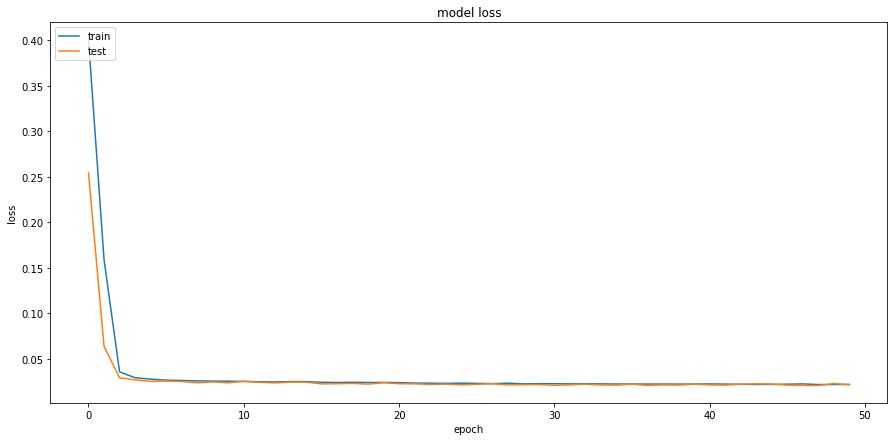

In [14]:
score_train = modelC1.evaluate(x0, y0, verbose=0)
score_val = modelC1.evaluate(x2, y2, verbose=0)
print(f"Train MSE: {score_train[0]}")
print(f"Validate MSE: {score_val[0]}")
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15, 7))
axes.plot(history.history['mse'])
axes.plot(history.history['val_mse'])
axes.set_title('model loss')
axes.set_ylabel('loss')
axes.set_xlabel('epoch')
axes.legend(['train', 'test'], loc='upper left');

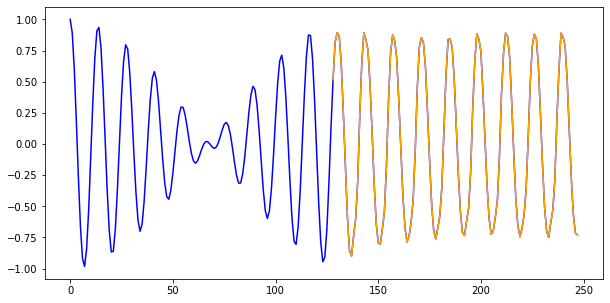

In [29]:
n_tests = 1
x_test,y_test = gen_data(size=n_tests,noise=0.0)
for i in range(12):
    y = modelC1.predict(x_test)
    x_test = np.concatenate((x_test, y), axis=1)
y_pred = x_test[:, 128:]


fig = plt.figure(figsize=(10, 5))
for i in range(n_tests):
    plt.plot(range(0, 248),x_test[i,:,0],'b-')
    plt.plot(range(128, 248),y_pred[i,:,0],'b-', color='orange')

### C2)

In [16]:
n_epochs = 50
batch_size = 8
lr = 1e-3
look_ahead = 10

modelC2 = Sequential()
modelC2.add(SimpleRNN(units=12, input_shape=(None, 1), return_sequences=True, activation="relu"))
modelC2.add(SimpleRNN(units=24, return_sequences=True, activation="relu"))
modelC2.add(SimpleRNN(units=48, return_sequences=True, activation="relu"))
modelC2.add(Dense(1))
modelC2.add(Lambda(slice, arguments={'slice_length':look_ahead}))
modelC2.compile(optimizer="adam", loss='mse', lr=lr, metrics=['mse'])
modelC2.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, None, 12)          168       
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, None, 24)          888       
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, None, 48)          3504      
_________________________________________________________________
dense_3 (Dense)              (None, None, 1)           49        
_________________________________________________________________
lambda_3 (Lambda)            (None, None, 1)           0         
Total params: 4,609
Trainable params: 4,609
Non-trainable params: 0
_________________________________________________________________


In [17]:
history = modelC2.fit(x0, y0, batch_size=batch_size, epochs=n_epochs, validation_data=(x2, y2));

Train on 800 samples, validate on 200 samples
Epoch 1/50
800/800 [==============================] - 17s 21ms/sample - loss: 0.0707 - mse: 0.0707 - val_loss: 0.0235 - val_mse: 0.0235
Epoch 2/50
800/800 [==============================] - 14s 18ms/sample - loss: 0.0253 - mse: 0.0253 - val_loss: 0.0250 - val_mse: 0.0250
Epoch 3/50
800/800 [==============================] - 14s 18ms/sample - loss: 0.0219 - mse: 0.0219 - val_loss: 0.0185 - val_mse: 0.0185
Epoch 4/50
800/800 [==============================] - 14s 17ms/sample - loss: 0.0194 - mse: 0.0194 - val_loss: 0.0183 - val_mse: 0.0183
Epoch 5/50
800/800 [==============================] - 14s 17ms/sample - loss: 0.0171 - mse: 0.0171 - val_loss: 0.0154 - val_mse: 0.0154
Epoch 6/50
800/800 [==============================] - 14s 17ms/sample - loss: 0.0166 - mse: 0.0166 - val_loss: 0.0164 - val_mse: 0.0164
Epoch 7/50
800/800 [==============================] - 14s 18ms/sample - loss: 0.0163 - mse: 0.0163 - val_loss: 0.0161 - val_mse: 0.0161
Ep

Train MSE: 0.013046448677778244
Validate MSE: 0.012889716140925885


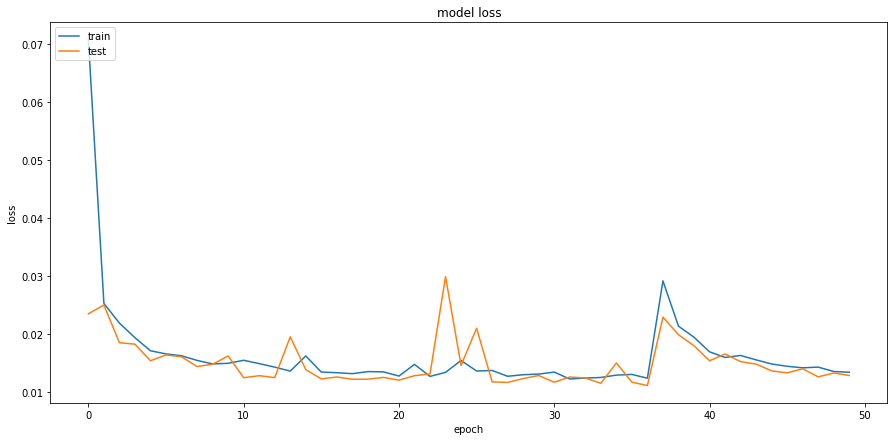

In [18]:
score_train = modelC2.evaluate(x0, y0, verbose=0)
score_val = modelC2.evaluate(x2, y2, verbose=0)
print(f"Train MSE: {score_train[0]}")
print(f"Validate MSE: {score_val[0]}")
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15, 7))
axes.plot(history.history['mse'])
axes.plot(history.history['val_mse'])
axes.set_title('model loss')
axes.set_ylabel('loss')
axes.set_xlabel('epoch')
axes.legend(['train', 'test'], loc='upper left');

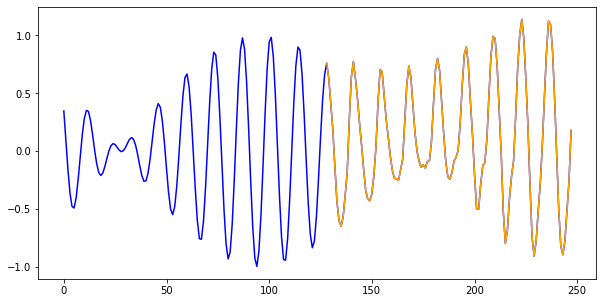

In [30]:
n_tests = 1
x_test,y_test = gen_data(size=n_tests,noise=0.0)
for i in range(12):
    y = modelC2.predict(x_test)
    x_test = np.concatenate((x_test, y), axis=1)
y_pred = x_test[:, 128:]


fig = plt.figure(figsize=(10, 5))
for i in range(n_tests):
    plt.plot(range(0, 248),x_test[i,:,0],'b-')
    plt.plot(range(128, 248),y_pred[i,:,0],'b-', color='orange')

## D) LSTM Cell

### D1)

In [20]:
n_epochs = 50
batch_size = 8
lr = 1e-3
look_ahead = 10

modelD1 = Sequential()
modelD1.add(LSTM(units=12, input_shape=(None, 1), return_sequences=True, activation="relu"))
modelD1.add(Dense(1))
modelD1.add(Lambda(slice, arguments={'slice_length':look_ahead}))
modelD1.compile(optimizer="adam", loss='mse', lr=lr, metrics=['mse'])
modelD1.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, None, 12)          672       
_________________________________________________________________
dense_4 (Dense)              (None, None, 1)           13        
_________________________________________________________________
lambda_4 (Lambda)            (None, None, 1)           0         
Total params: 685
Trainable params: 685
Non-trainable params: 0
_________________________________________________________________


In [21]:
history = modelD1.fit(x0, y0, batch_size=batch_size, epochs=n_epochs, validation_data=(x2, y2));

Train on 800 samples, validate on 200 samples
Epoch 1/50
800/800 [==============================] - 11s 14ms/sample - loss: 0.2330 - mse: 0.2330 - val_loss: 0.1463 - val_mse: 0.1463
Epoch 2/50
800/800 [==============================] - 10s 12ms/sample - loss: 0.1469 - mse: 0.1469 - val_loss: 0.1408 - val_mse: 0.1408
Epoch 3/50
800/800 [==============================] - 10s 12ms/sample - loss: 0.1394 - mse: 0.1394 - val_loss: 0.1325 - val_mse: 0.1325
Epoch 4/50
800/800 [==============================] - 10s 13ms/sample - loss: 0.1245 - mse: 0.1245 - val_loss: 0.0937 - val_mse: 0.0937
Epoch 5/50
800/800 [==============================] - 10s 13ms/sample - loss: 27925.2629 - mse: 27925.2812 - val_loss: 0.1258 - val_mse: 0.1258
Epoch 6/50
800/800 [==============================] - 10s 13ms/sample - loss: 0.1275 - mse: 0.1275 - val_loss: 0.1245 - val_mse: 0.1245
Epoch 7/50
800/800 [==============================] - 10s 13ms/sample - loss: 0.1262 - mse: 0.1262 - val_loss: 0.1233 - val_mse: 0

Train MSE: 0.09777684926986695
Validate MSE: 0.09653134375810624


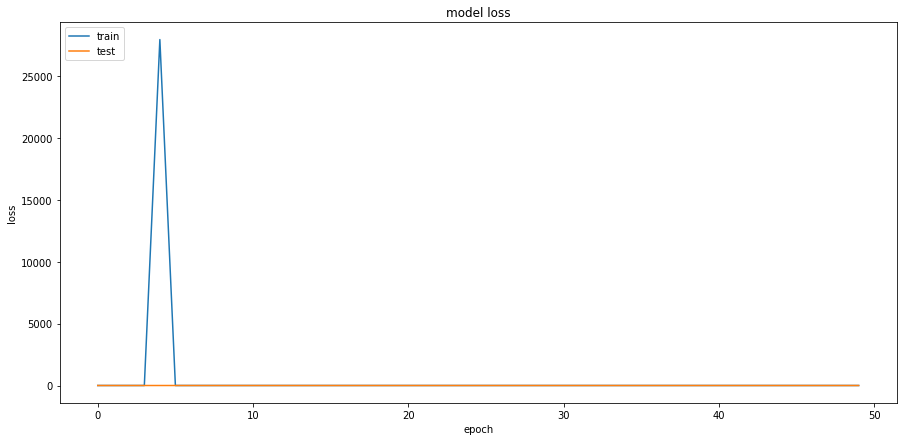

In [22]:
score_train = modelD1.evaluate(x0, y0, verbose=0)
score_val = modelD1.evaluate(x2, y2, verbose=0)
print(f"Train MSE: {score_train[0]}")
print(f"Validate MSE: {score_val[0]}")
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15, 7))
axes.plot(history.history['mse'])
axes.plot(history.history['val_mse'])
axes.set_title('model loss')
axes.set_ylabel('loss')
axes.set_xlabel('epoch')
axes.legend(['train', 'test'], loc='upper left');

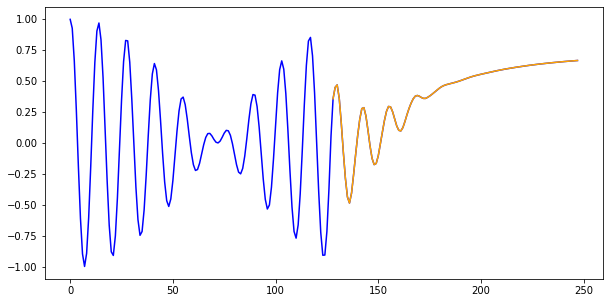

In [31]:
n_tests = 1
x_test,y_test = gen_data(size=n_tests,noise=0.0)
for i in range(12):
    y = modelD1.predict(x_test)
    x_test = np.concatenate((x_test, y), axis=1)
y_pred = x_test[:, 128:]


fig = plt.figure(figsize=(10, 5))
for i in range(n_tests):
    plt.plot(range(0, 248),x_test[i,:,0],'b-')
    plt.plot(range(128, 248),y_pred[i,:,0],'b-', color='orange')

### D2)

In [33]:
n_epochs = 50
batch_size = 8
lr = 1e-3
look_ahead = 10

modelD2 = Sequential()
modelD2.add(LSTM(units=12, input_shape=(None, 1), return_sequences=True, activation="relu"))
modelD2.add(LSTM(units=6, return_sequences=True, activation="relu"))
modelD2.add(LSTM(units=3, return_sequences=True, activation="relu"))
modelD2.add(Dense(1))
modelD2.add(Lambda(slice, arguments={'slice_length':look_ahead}))
modelD2.compile(optimizer="adam", loss='mse', lr=lr, metrics=['mse'])
modelD2.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, None, 12)          672       
_________________________________________________________________
lstm_8 (LSTM)                (None, None, 6)           456       
_________________________________________________________________
lstm_9 (LSTM)                (None, None, 3)           120       
_________________________________________________________________
dense_7 (Dense)              (None, None, 1)           4         
_________________________________________________________________
lambda_7 (Lambda)            (None, None, 1)           0         
Total params: 1,252
Trainable params: 1,252
Non-trainable params: 0
_________________________________________________________________


In [34]:
history = modelD2.fit(x0, y0, batch_size=batch_size, epochs=n_epochs, validation_data=(x2, y2));

Train on 800 samples, validate on 200 samples
Epoch 1/50
800/800 [==============================] - 30s 37ms/sample - loss: 0.6750 - mse: 0.6750 - val_loss: 0.2530 - val_mse: 0.2530
Epoch 2/50
800/800 [==============================] - 27s 34ms/sample - loss: 0.2555 - mse: 0.2555 - val_loss: 0.2532 - val_mse: 0.2532
Epoch 3/50
800/800 [==============================] - 26s 33ms/sample - loss: 0.2554 - mse: 0.2554 - val_loss: 0.2530 - val_mse: 0.2530
Epoch 4/50
800/800 [==============================] - 26s 32ms/sample - loss: 0.2553 - mse: 0.2553 - val_loss: 0.2529 - val_mse: 0.2529
Epoch 5/50
800/800 [==============================] - 26s 32ms/sample - loss: 0.2551 - mse: 0.2551 - val_loss: 0.2528 - val_mse: 0.2528
Epoch 6/50
800/800 [==============================] - 26s 33ms/sample - loss: 0.2550 - mse: 0.2550 - val_loss: 0.2526 - val_mse: 0.2526
Epoch 7/50
800/800 [==============================] - 27s 33ms/sample - loss: 0.2548 - mse: 0.2548 - val_loss: 0.2524 - val_mse: 0.2524
Ep

Train MSE: 0.03126000255346298
Validate MSE: 0.029774277061223983


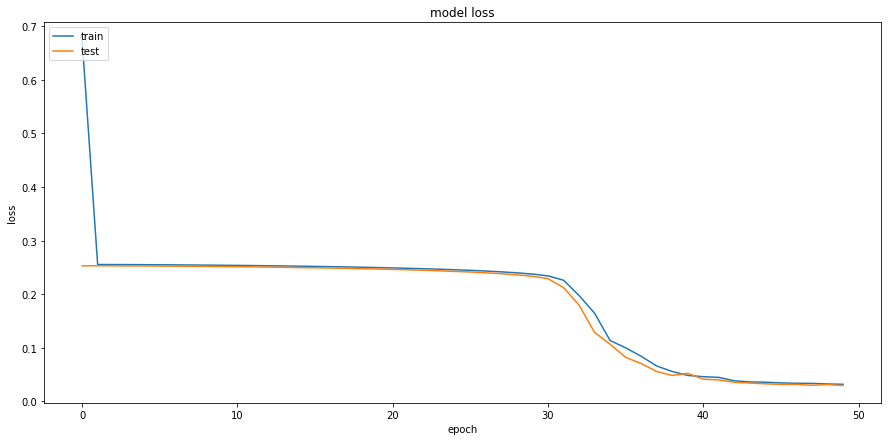

In [35]:
score_train = modelD2.evaluate(x0, y0, verbose=0)
score_val = modelD2.evaluate(x2, y2, verbose=0)
print(f"Train MSE: {score_train[0]}")
print(f"Validate MSE: {score_val[0]}")
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15, 7))
axes.plot(history.history['mse'])
axes.plot(history.history['val_mse'])
axes.set_title('model loss')
axes.set_ylabel('loss')
axes.set_xlabel('epoch')
axes.legend(['train', 'test'], loc='upper left');

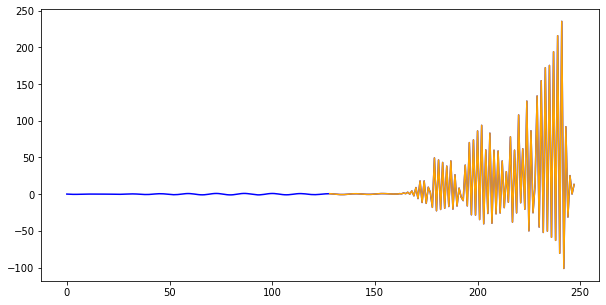

In [36]:
n_tests = 1
x_test,y_test = gen_data(size=n_tests,noise=0.0)
for i in range(12):
    y = modelD2.predict(x_test)
    x_test = np.concatenate((x_test, y), axis=1)
y_pred = x_test[:, 128:]


fig = plt.figure(figsize=(10, 5))
for i in range(n_tests):
    plt.plot(range(0, 248),x_test[i,:,0],'b-')
    plt.plot(range(128, 248),y_pred[i,:,0],'b-', color='orange')